### 1. Data imports

In [1]:
import pandas as pd
import pyreadr
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# preprocessing
from sklearn.preprocessing import PowerTransformer, LabelEncoder

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

# Model assement functionality
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

# visualization, display and printing
from IPython.display import display, Math

%matplotlib inline

### 1. Configurations and loading data

In [2]:
sns.set_theme(style="white")
result = pyreadr.read_r('./data/segm.RData')
df = result['segmentationOriginal'][['EqSphereAreaCh1', 'PerimCh1', 'Class', 'Case']]

df.columns = ['A', 'B', 'Class', 'Case']

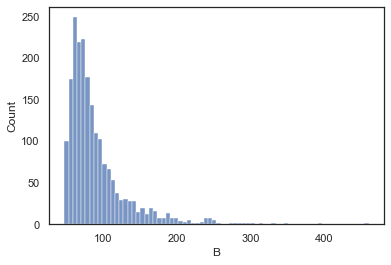

In [3]:
sns.histplot(df['B']);
# sns.histplot(df['A'])

#### We see a right skeweness which can be removed with a transformation

#### We use 1/x transformation to scatter points which are more concentrated near 0 to remove skeweness

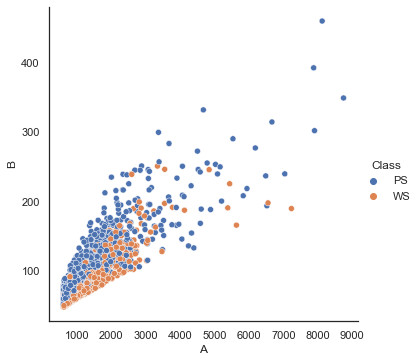

In [4]:
sns.relplot(x=df.A, y=df.B, hue=df.Class);

In [5]:
power_transform_bc = PowerTransformer(method='box-cox')
power_transform_bc.fit(df[['A', 'B']])
lambdas = [str(round(x, 2)) for x in power_transform_bc.lambdas_]
print("Estimated lambdas of the box cox transform are:", ', '.join(lambdas))

transformed_feat_arr = power_transform_bc.transform(df[['A', 'B']])

tr_features_df = pd.DataFrame(transformed_feat_arr)

tr_features_df.columns = ['A', 'B']
sns.relplot(data=tr_features_df, x=tr_features.A, y=tr_features_df.B, hue=df.Class)

Estimated lambdas of the box cox transform are: -0.94, -1.16


NameError: name 'tr_features' is not defined

The box-cox transform Power Transform method assumes normality of the [following transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation)
and then uses the log likelihood function to find best parameter for $\lambda$ using a scipy optimize method

## Logistic Regression model

In [ ]:
le = LabelEncoder()
le.fit(['WS', 'PS']) # encode PS as success
response = le.transform(df['Class']) # encoded classes as 0s, 1s

X_train, X_test, y_train, y_test = train_test_split(df[['A', 'B']], response, test_size=0.5,
                                                   random_state=1)
lr = LogisticRegression(fit_intercept=True)
fit = lr.fit(X_train, y_train)

# print the estimated coefficients of the model
beta0, beta1, beta2 = [round(x, 3) for x in np.append(fit.intercept_, fit.coef_)]

print('The estimated parameters are: ')
display(Math(r'\beta_0 = {}, \beta_1 = {}, \beta_2={} '.format(beta0, beta1, beta2)))

In [ ]:
plot_roc_curve(lr, X_test, y_test);

### The next model improves accuracy after removing skeweness with the box-cox transformation of the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tr_features_df, response, test_size=0.5, random_state=1)
lr = LogisticRegression(fit_intercept=True, penalty='none')
fit = lr.fit(X_train, y_train)

beta0, beta1, beta2 = [round(x, 3) for x in np.append(fit.intercept_, fit.coef_)]

print('The estimated parameters are: ')
display(Math(r'\beta_0 = {}, \beta_1 = {}, \beta_2={} '.format(beta0, beta1, beta2)))

#### Plotting the ROC Curve and estimating the auc of the roc curve

We look for the up-left most point on the curve.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

In [ ]:
plot_roc_curve(lr, X_test, y_test);

## Trying different models for improvement of accuracy

### kNN classification model

In [ ]:
neighbours_clf = KNeighborsClassifier(n_neighbors=10)
neighbours_clf.fit(X_train, y_train)

plot_roc_curve(neighbours_clf, X_test, y_test);

### Neural Network model

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)

In [ ]:
plot_roc_curve(mlp, X_test, y_test);

##### Seems to be giving a slightly better AUC score

##### "The more predictively accurate the model is, the more faith can be put into the variables that it fingers as important"
Breiman

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)
plot_roc_curve(clf, X_test, y_test);